In [1]:
# In this Example I take a Surface and Sonify it. This can be used to sonify pixels and other materials

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  #For 3d plotting
from matplotlib.pylab import cm
import numpy as np
import random as rand

from midiutil import MIDIFile

%matplotlib inline

X:  [-3.   -2.95 -2.9  -2.85 -2.8 ]
Y:  [-3. -3. -3. -3. -3.]
Z:  [12.     11.7025 11.41   11.1225 10.84  ]


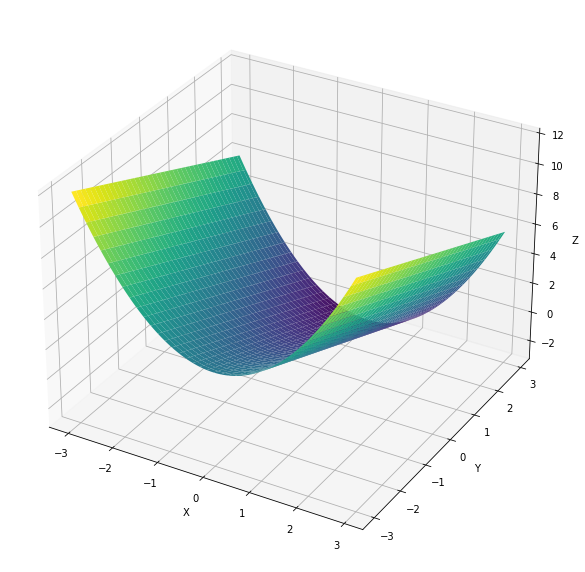

In [2]:
# Let's plot a few surfaces

def f1(x, y):
    return x**2 - y

x = y = np.arange(-3.0, 3.0, 0.05) #range -3 to 3 by steps of 0.05
X, Y = np.meshgrid(x, y) #Makes a Meshgrid
zs = np.array(f1(X, Y)) 
Z = zs.reshape(X.shape)

fig = plt.figure(figsize=(10,12))
ax = fig.add_subplot(projection='3d')

ax.plot_surface(X, Y, Z, cmap='viridis')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

print('X: ', X[0][0:5])
print('Y: ', Y[0][0:5])
print('Z: ', Z[0][0:5])

In [3]:
#What would this sound like? Well it really depends on how we travel over it.
    #If we travel in slices along the X or Y Axis, then the shape of the slice is either a Parabola or a Slanted Line. 
    #If we travel along the Z axis we get 2 seperate pieces slowly coming together until we pass through the entire serface.
    #If we drove a car on the surface we could explore the space in almost any path.
    #We could even slice radially from a center point.

(-5.0, 13.0)

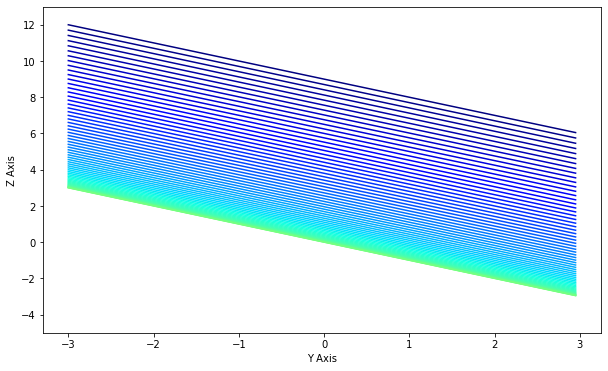

In [4]:
#Lets start by moving across the X axis (left to right in the above graph). This gives us diaganol lines to sonify.
zslice = np.zeros((120, 120))

for i in range(len(X[0])):
    for j in range(len(X[0])):
        zslice[i][j] = Z[j][i]
    
fig, ax = plt.subplots(1, figsize=(10,6))
colors = cm.jet(np.linspace(0,1,120))

for i in range(60):
    ax.plot(X[0], zslice[i], color=colors[i])

ax.set_xlabel('Y Axis')
ax.set_ylabel('Z Axis')
plt.ylim([-5, 13])

In [10]:
#So as we move across the X axis the slope stays constant but the line itself goes Down then Up again.
#Let's make a Chord using the Z Axis, then use a CC parameter to make the U shape as we travel across.

#Let's set up the functions we had before. I still have to put them into classes so these are just copied from the other notebooks.

def set_midi_notes_for_mode(start_note, octaves, mode):
    #Returns a list of Diatonic Notes in the Mode
    #Returns a 2nd list of Accidental Notes not in the Mode
    
    modes = {
    'ionian':[2,2,1,2,2,2,1],
    'dorian':[2,1,2,2,2,1,2],
    'phrygian':[1,2,2,2,1,2,2],
    'lydian':[2,2,2,1,2,2,1],
    'mixolydian':[2,2,1,2,2,1,2],
    'aeolian':[2,1,2,2,1,2,2],
    'lochrian':[1,2,2,1,2,2,2]
    }
    
    diatonics = []
    accidentals = []
    
    for octave in range(octaves):
        note = start_note + (12*octave) #first octave = 0, 2nd=1, etc
        
        for step in modes[mode]:
            diatonics.append(note)
            note = note + step
    last_note = start_note + (octaves*12) #sets last note
    diatonics.append(last_note) #there must be a better way to do this
    
    for i in range(octaves*12): #in range of all semitones
        note = start_note + i
        
        if note not in diatonics:
            accidentals.append(note)
            
    return diatonics, accidentals

def Map_Data_to_MidiNotes_InMode(data, midilist, target_n):
    #Takes data and forces it upon a list of midi notes
    
    step = int(len(data)/target_n)
    data = data[0::step]
    nout = np.interp(data, (data.min(), data.max()), (0, len(midilist)-1))
    out = np.zeros((2, len(nout))) #Set official out array, data:midi

    for i in range(len(nout)):
        s = int(np.round(nout[i]))
        out[0,i] = data[i]
        out[1,i] = midilist[s]
        
    return out  

def Map_Data_to_CC(data, target_n):
    #Takes data and maps to CC space
    
    cc = np.linspace(0,127,128)
    
    step = int(len(data)/target_n)
    data = data[0::step]
    nout = np.interp(data, (data.min(), data.max()), (0, len(cc)-1))
    out = np.zeros((2, len(nout))) #Set official out array, data:midi
    
    for i in range(len(nout)):
        s = int(np.round(nout[i]))
        out[0,i] = data[i]
        out[1,i] = s
    
    return out


Diatonics: [60, 62, 64, 65, 67, 69, 71, 72, 74, 76, 77, 79, 81, 83, 84]
Midi Notes Selected: [84. 77. 72. 67. 60.]
CC Data 0-10/end: [127. 123. 119. 115. 111. 107. 103.  99.  95.  92.] [ 85.  88.  92.  95.  99. 103. 107. 111. 115. 119.]


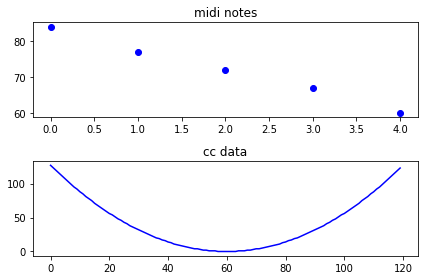

In [11]:
# First we need to decide two seperate sample rates. The Moving of the X axis (U shaped), the notes on the ZY plane (Line Shaped).
# Let's start with just a 5 note chord.

start_note = 60 #Middle C
octaves = 2 #3octave span
mode = 'ionian'
diatonics, accidentals = set_midi_notes_for_mode(start_note, octaves, mode)
print('Diatonics:', diatonics)

target_n = 5 #3 Only 5 points of the 120
midi_notes = Map_Data_to_MidiNotes_InMode(zslice[0], diatonics, target_n)
print('Midi Notes Selected:', midi_notes[1])

#We only Interpolate for a single Z slice since the slope does not change. 
# If the slope did change we would interpolate for every slice

#Now Let's sample for our CC parameter
cc_data = Map_Data_to_CC(Z[0], 120)
print('CC Data 0-10/end:', cc_data[1][0:10], cc_data[1][109:119])

fig, ax = plt.subplots(2)
ax[0].plot(midi_notes[1], 'bo')
ax[0].set_title('midi notes')
ax[1].plot(cc_data[1], 'b')
ax[1].set_title('cc data')
plt.tight_layout()

In [12]:
# Let's make the file now, we need to first write a note chord and then write the CC values. Since our data is 120 points long, 120bpm will be optimal
# We'll now define a way to write midi chords per slice of array

# We'll pass around our midi file and write it at the very end.

def make_chords_midifile(bpm, note_duration, midi_data):
    #Note duration referes to each chord length, a chord is an array inside the notes array
    
    track = 0
    channel = 0
    velocity = 100 #Constant for now
    miditime = 0
    
    mymidi = MIDIFile(1, eventtime_is_ticks=True)
    mymidi.addTempo(track, miditime, bpm)
    
    
    #Some calculations to approximate length in seconds
    # qnps = 1/(bpm/60.)*4 #quarter per sec
    spq = 1/(bpm/60.)
    note_time = note_duration / 960.
    tot_notetime = spq*note_time
    print('File Length:', len(midi_data)*(tot_notetime), 'seconds')
    
    #Instead of just iterating through notes, we'll open up the array and get the notes of each chord.
    for notes in range(len(midi_data)):
        chord = midi_data[notes]
        
        for note in chord:
            mymidi.addNote(track, channel, int(note), miditime, note_duration, velocity)
        
        miditime += note_duration
        
    return mymidi   

def alt_make_cc_midifile(midifile, CCpoint_duration, cc_data, channel_num):
    
    track = 0
    channel = 0
    miditime = 0
    
    mymidi = midifile
    
    for i in range(len(cc_data)):
        mymidi.addControllerEvent(track, channel, miditime, channel_num, int(cc_data[i]))
        miditime += CCpoint_duration
    
    return mymidi

def alt_basic_diatonic_midifile(bpm, note_duration, midi_data):
    
    track = 0
    channel = 0
    velocity = 100 #Constant for now
    miditime = 0
    
    mymidi = MIDIFile(1, eventtime_is_ticks=True)
    mymidi.addTempo(track, miditime, bpm)
    
    
    #Some calculations to approximate length in seconds
    # qnps = 1/(bpm/60.)*4 #quarter per sec
    spq = 1/(bpm/60.)
    note_time = note_duration / 960.
    tot_notetime = spq*note_time
    print('File Length:', len(midi_data)*(tot_notetime), 'seconds')
    
    for note in range(len(midi_data)):
        mymidi.addNote(track, channel, int(midi_data[note]), miditime, note_duration, velocity)
        miditime += note_duration
    
    return mymidi

In [13]:
#Using the above function to get our notes into the midifile
#Making Chords 
midi_chords = [midi_notes[1]] #When we play more than one chord we'll have an array full of chord arrays. This is making a single version of that.

#calculations for note length (one long note) Using the NOTE DATA
bpm = 120
spb = 1/(120/60.)

tscore_target = 30 #30 seconds long
div = tscore_target / len(midi_chords)
note_duration = int((960*div)/spb) #What we Want to know
print('Note duration in Ticks:', note_duration)

total_ticks = (note_duration * len(midi_chords))
actual_scoretime = (total_ticks/960)*spb
print('Actual Score Time (sec): ', actual_scoretime)

midifile = make_chords_midifile(bpm, note_duration, midi_chords) #Adding the Chords In

Note duration in Ticks: 57600
Actual Score Time (sec):  30.0
File Length: 30.0 seconds


In [14]:
#Using the altered cc function to map to midifile

#calculating division rate

div = actual_scoretime / len(cc_data[1]) #seconds per data point
CCpoint_duration = int(np.round((960*div)/spb)) #What we Want to know
print('CC point Duration in Ticks:', CCpoint_duration)

midifile = alt_make_cc_midifile(midifile, CCpoint_duration, cc_data[1], channel_num=3)

CC point Duration in Ticks: 480


In [15]:
#let's Write the file now

outfile_name = '4_BasicSurfaceMidi'

with open("MidiFiles/{}.mid".format(outfile_name), "wb") as output_file:
        midifile.writeFile(output_file)

In [ ]:
# Some Thoughts:

# Really ponder your parameters here. Depending on the slice direction we get very different outputs. 
# Sound is a hologram, it projects countless dimensions onto only 2, time and audio
# It is up to you to make the audio portion 'seem' multidimensional. Pitch vs time, frequency, timbre, resonances, chords,
# all of these only give the illusion of multidimensionalness within sound but it's the key. Think of your sonification as an array
# size 2x1 ([time, [sounds]]) and within the sounds array you can have infinite changes. Regardless it is those changes over time
# that provide information audibly.